In [1]:
import uproot
import numpy as np
import numba
import awkward1 as ak
import awkward as ak0

In [2]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib import rcParams
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import                                                                                                                  
import mplhep as hep
plt.style.use(hep.style.ROOT)
import os,sys
import pandas as pd
from scipy.stats import halfnorm

In [3]:
def getData(fname="", procName="Truth"):
    dq_dict = uproot.open(fname)["Truth"].arrays()
    dq_dict_ak1 = {name.decode(): ak.from_awkward0(array) for name, array in dq_dict.items()}
    dq_events = ak.zip({"Hits":ak.zip({
                                      "detID":   dq_dict_ak1["hit_detID"],
                                      "edep":    dq_dict_ak1["hit_edep"],
                                      "elmID":   dq_dict_ak1["hit_elmID"],
                                      "truthx":  dq_dict_ak1["hit_truthx"],
                                      "truthy":  dq_dict_ak1["hit_truthy"],
                                      "truthz":  dq_dict_ak1["hit_truthz"],
                                      }),
                        "Electrons":ak.zip({
                                            "ge":      dq_dict_ak1["ge"],
                                        }),
                       }, depth_limit=1)
    return dq_events

In [4]:
def emcal_selection(arr):
    mask = (arr.detID == 100)
    return mask

def h2_selection(arr):
    mask = (arr.detID >= 35) & (arr.detID <= 38)
    return mask

def st2_selection(arr):
    mask = (arr.detID >= 13) & (arr.detID <= 18)
    return mask

def st3_selection(arr):
    mask = (arr.detID >= 19) & (arr.detID <= 30)
    return mask

def h4_selection(arr):
    mask = (arr.detID >= 41) & (arr.detID <= 46)
    return mask

In [5]:
def emcal_byevent(ifile,evtNum):
    Mass=ifile.split("_")[3]+" GeV"
    Type=ifile.split("_")[2]
    
    #EMCAL
    ntowersx=72
    ntowersy=36
    sizex=5.53
    sizey=5.53

    ecalx=[-200,200] #size in cm
    ecaly=[-100,100]
    binsx=ecalx[1]-ecalx[0]
    binsy=ecaly[1]-ecaly[0]

    dq_events = getData(ifile,"Truth")
    dq_hits = dq_events[evtNum]["Hits"]
    dq_electrons = dq_events[evtNum]["Hits"]
    emcal_mask = emcal_selection(dq_hits)
    emcal_hits = dq_hits[emcal_mask]
    emcal_towerx = emcal_hits.elmID//ntowersy
    emcal_towery = emcal_hits.elmID%ntowersy
    emcal_truthx = emcal_hits.truthx
    emcal_truthy = emcal_hits.truthy
    emcal_x = ecalx[0]+emcal_towerx*sizex
    emcal_y = ecaly[0]+emcal_towery*sizey
    emcal_edep = emcal_hits.edep
    
    st3_mask = st3_selection(dq_hits)
    st3_hits = dq_hits[st3_mask]

    st2_mask = st2_selection(dq_hits)
    st2_hits = dq_hits[st2_mask]
    st2_truthx = st2_hits.truthx
    st2_truthy = st2_hits.truthy
    
    h2_mask = h2_selection(dq_hits)
    h2_hits = dq_hits[h2_mask]
    
    print("St3 hits %i, St2 hits %i, H2 hits %i"%(len(st3_hits),len(st2_hits),len(h2_hits)))
    print("Event "+str(evtNum)+": "+str(len(emcal_hits))+" hits")
    # not sure about this factor
    #con=(0.00051099895/0.00064903)
    #emcal_edep=emcal_edep*con

    # Plot towers
    fig = plt.figure(figsize=(8,6))
    plt.hist2d(np.array(emcal_towerx),np.array(emcal_towery), bins=[ntowersx,ntowersy], range=[[0,ntowersx],[0,ntowersy]], density=False)
    plt.xlabel("Tower x")
    plt.ylabel("Tower y")
    cbar=plt.colorbar()
    cbar.set_label('Counts')
    plt.title("Unweighted Counts for "+Type+": "+Mass+" \n Event "+str(evtNum))
    plt.show()

    # weighted
    fig = plt.figure(figsize=(8,6))
    plt.hist2d(np.array(emcal_towerx),np.array(emcal_towery), bins=[ntowersx,ntowersy], range=[[0,ntowersx],[0,ntowersy]], weights=np.array(emcal_edep), density=False)
    plt.xlabel("Tower x")
    plt.ylabel("Tower y")
    cbar=plt.colorbar()
    cbar.set_label('Energy Deposit [MeV]')
    plt.title("Energy Deposits for "+Type+": "+Mass+" \n Event "+str(evtNum))
    plt.show()

    # Plot x and y from towers
    fig = plt.figure(figsize=(8,6))
    plt.hist2d(np.array(emcal_x),np.array(emcal_y), bins=[int(binsx/sizex),int(binsy/sizey)], range=[ecalx,ecaly], density=False)
    plt.xlabel("Tower x")
    plt.ylabel("Tower y")
    cbar=plt.colorbar()
    cbar.set_label('Counts')
    plt.title("Unweighted Counts for "+Type+": "+Mass+" \n Event "+str(evtNum))
    plt.show()

    # weighted
    fig = plt.figure(figsize=(8,6))
    plt.hist2d(np.array(emcal_x),np.array(emcal_y), bins=[int(binsx/sizex),int(binsy/sizey)], range=[ecalx,ecaly], weights=np.array(emcal_edep), density=False)
    plt.xlabel("Tower x")
    plt.ylabel("Tower y")
    cbar=plt.colorbar()
    cbar.set_label('Energy Deposit [MeV]')
    plt.title("Energy Deposits for "+Type+": "+Mass+" \n Event "+str(evtNum))
    plt.show()

    # Plot truth x and y
    fig = plt.figure(figsize=(8,6))
    plt.hist2d(np.array(emcal_truthx),np.array(emcal_truthy), bins=[binsx,binsy], range=[ecalx,ecaly], density=False)
    plt.xlabel("Truth x")
    plt.ylabel("Truth y")
    cbar=plt.colorbar()
    cbar.set_label('Counts')
    plt.title("Unweighted Counts for "+Type+": "+Mass+" \n Event "+str(evtNum))
    plt.show()
    
    # Plot st2
    fig = plt.figure(figsize=(8,6))
    plt.hist2d(np.array(st2_truthx),np.array(st2_truthy), bins=[binsx,binsy], range=[ecalx,ecaly], density=False)
    plt.xlabel("St2 Truth x")
    plt.ylabel("St2 Truth y")
    cbar=plt.colorbar()
    cbar.set_label('Counts')
    plt.title("St2 Counts for "+Type+": "+Mass+" \n Event "+str(evtNum))
    plt.show()

    # build towers
    #H, xedges, yedges = np.histogram2d(np.array(emcal_towerx), np.array(emcal_towery), bins=(range(ntowersx), range(ntowersy)))

St3 hits 0, St2 hits 12, H2 hits 4
Event 8: 51 hits


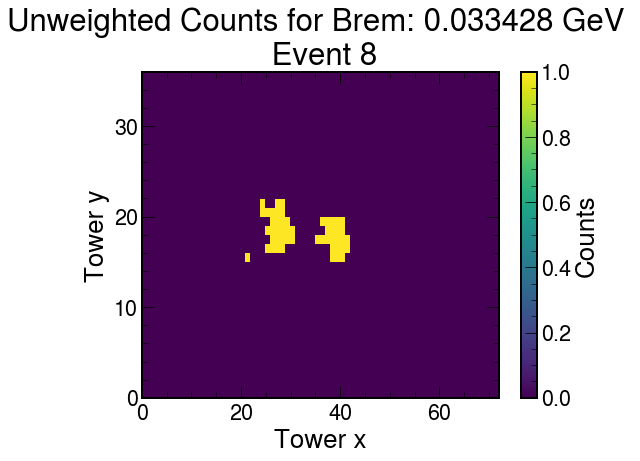

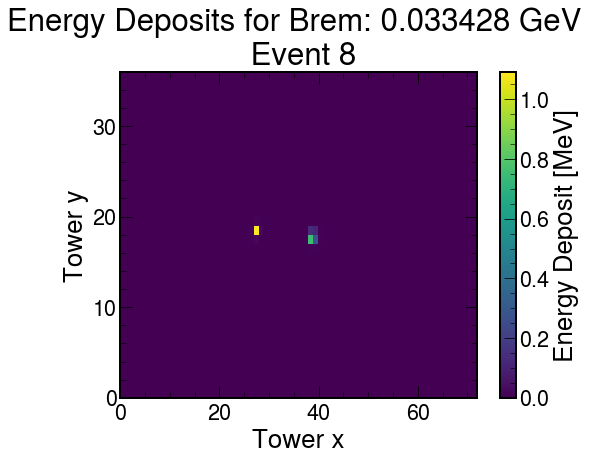

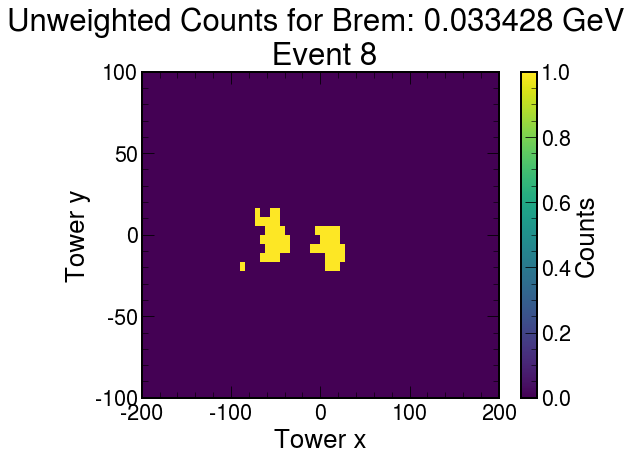

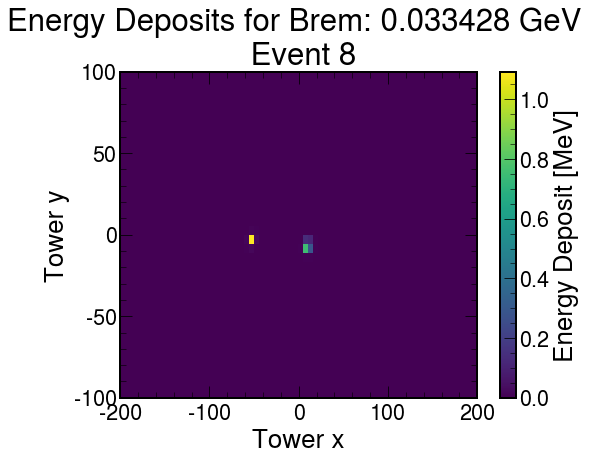

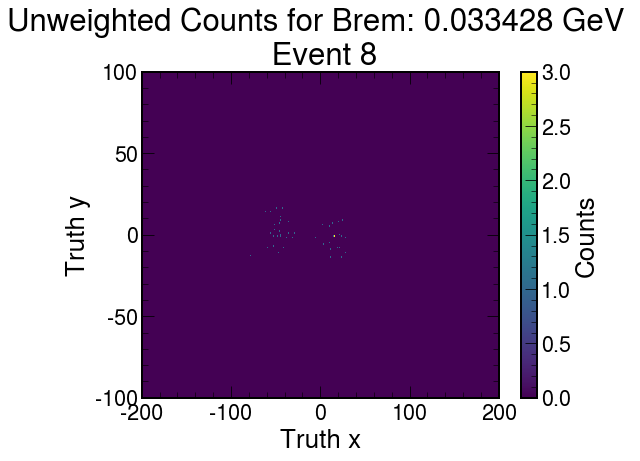

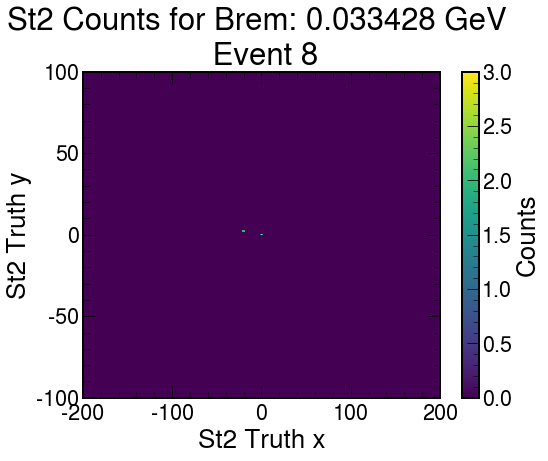

In [6]:
ifileBrem = "sim_eval_Brem_0.033428_z500_600_eps_-5.2.root"
emcal_byevent(ifileBrem,8)